# NEXT Tests

This Notebook tests and demonstrates TempEst-NEXT for generating NEWT models.

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import pickle
from pygam import LinearGAM, s, te, l, f
from NEWT import kfold
from NEXT import NEXT, coef_est

In [2]:
def idfix(data):
    data = data[data["id"].apply(lambda x: x.startswith("USGS"))]
    data["id"] = data["id"].apply(lambda x: x.split("_")[1])
    return data

In [3]:
data = pd.read_csv("AllData.csv", dtype={"id": "str"}).rename(columns={"temperature.mean": "temperature"})
data = data[(data["temperature"] > -0.1) & (data["temperature"] < 50)]  # basic QA
data["date"] = pd.to_datetime(data["date"])
data["day"] = data["date"].dt.day_of_year
gsamp = pd.read_csv("GageSample.csv",
                   dtype={"id": "str"})
lcov = idfix(pd.read_csv("LandCover.csv"))
area = idfix(pd.read_csv("Area.csv"))
topo = idfix(pd.read_csv("Topography.csv"))
data = data.merge(lcov, on="id").merge(area, on="id").merge(topo, on="id").merge(gsamp[["id", "lat", "lon"]], on="id")
data

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,day,...,ice_snow,area,elev,elev_min,elev_std,slope,asp_north,asp_east,lat,lon
0,13011820,2020-03-31,0.100000,17.110126,248.76216,NaN,1.795443,NaN,444.26370,91,...,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,0.000243,0.003187,0.002841,43.807111,-110.178722
1,13011820,2020-04-01,0.100000,7.202532,403.38873,NaN,0.030759,NaN,270.94354,92,...,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,0.000243,0.003187,0.002841,43.807111,-110.178722
2,13011820,2020-04-02,0.100000,2.167848,600.86993,NaN,-3.442405,NaN,132.77936,93,...,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,0.000243,0.003187,0.002841,43.807111,-110.178722
3,13011820,2020-04-03,0.100000,2.987468,509.44165,NaN,-2.238481,NaN,138.35303,94,...,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,0.000243,0.003187,0.002841,43.807111,-110.178722
4,13011820,2020-04-04,0.100000,6.021518,465.97583,NaN,3.509114,NaN,284.43704,95,...,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,0.000243,0.003187,0.002841,43.807111,-110.178722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976628,03047000,2022-12-27,0.540625,0.000000,268.23563,NaN,-2.151775,NaN,207.79785,361,...,0.0,6.878668e+08,457.4157,257.871948,133.578278,0.000671,0.004324,0.003170,40.458889,-79.449444
2976629,03047000,2022-12-28,0.407292,0.000000,279.93356,NaN,5.509683,NaN,310.02664,362,...,0.0,6.878668e+08,457.4157,257.871948,133.578278,0.000671,0.004324,0.003170,40.458889,-79.449444
2976630,03047000,2022-12-29,0.428125,0.000000,290.53482,NaN,13.100331,NaN,354.31638,363,...,0.0,6.878668e+08,457.4157,257.871948,133.578278,0.000671,0.004324,0.003170,40.458889,-79.449444
2976631,03047000,2022-12-30,0.661458,0.000000,285.53320,NaN,17.568270,NaN,512.88240,364,...,0.0,6.878668e+08,457.4157,257.871948,133.578278,0.000671,0.004324,0.003170,40.458889,-79.449444


# Data Processing

In [4]:
ppd = coef_est.preprocess(data)
ppd

,id,tmax,prcp,srad,vp,area,elev_min,elev,slope,forest,...,cold_prcp,prcp_sd,srad_sd,vp_sd,ssn_phi,ssn_index,intercept,ksin,kcos,tamp
0,01010000,16.413223,3.773989,320.613812,968.749093,3.206001e+09,281.883179,421.54080,0.007291,0.846045,...,0.055349,6.315056,149.450027,430.352665,216.270692,0.540514,10.183701,-4.827292,-13.373083,14.217668
1,01011000,14.157408,3.813397,305.643412,862.312220,2.917139e+09,179.150101,362.70602,0.001996,0.878840,...,0.274958,6.561087,153.458731,455.495238,222.829319,0.382964,10.182508,-5.544706,-14.000452,15.058433
2,01018035,14.978195,3.339318,310.262448,905.622439,5.937122e+08,87.551575,175.52219,0.002190,0.565067,...,0.098891,6.995276,142.039525,495.077296,229.682793,0.285843,11.897104,-5.285002,-13.442177,14.443800
3,01038000,12.361746,3.628342,299.703362,877.559257,3.418957e+08,29.274170,109.47253,0.003414,0.675758,...,0.333177,8.565124,133.166733,555.611033,239.809530,0.084350,12.411499,-5.377854,-12.851322,13.931181
4,010642505,10.418935,4.341767,318.310318,735.133294,2.170877e+08,194.233963,704.23030,0.000221,0.969107,...,0.547478,8.663051,139.969164,474.622220,262.186041,0.141414,10.084860,-5.104671,-12.878405,13.853194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,385903107210800,17.943492,1.761172,457.622663,743.059231,5.632402e+08,1971.185913,2647.72120,0.000225,0.790240,...,0.000000,3.545819,113.087312,243.660423,186.241206,0.500117,11.893447,-4.284127,-11.356781,12.137966
926,394220106431500,9.372125,1.988381,404.831614,514.499609,1.419348e+09,2084.220703,3027.49410,0.000299,0.605191,...,0.574803,3.349789,147.347364,252.754076,47.872008,0.122565,9.466164,-3.972916,-10.774711,11.483834
927,402114105350101,11.580476,2.329381,470.890109,608.148517,9.442916e+07,2378.006348,3229.42850,0.000399,0.458394,...,0.483008,4.648200,155.307238,220.697633,172.126836,0.346147,6.876817,-4.462743,-11.078878,11.943937
928,404417108524900,17.077845,0.670020,365.317189,478.389025,2.335511e+06,1634.179199,1733.41830,0.000255,0.001728,...,0.032035,2.215789,125.916954,262.787681,220.626578,0.094023,16.928690,-4.684969,-13.954363,14.719822


In [11]:
# tdat = coef_est.build_training_data(data)
# tdat.to_csv("TrainingData.csv", index=False)
# tdat
tdat = pd.read_csv("TrainingData.csv")

# Model Preparation

In [7]:
# coefs = coef_est.build_model_from_data(tdat)
out = 'coefs.pickle'

In [8]:
# with open(out, 'wb') as f:
#     pickle.dump(coefs, f)

In [9]:
with open(out, 'rb') as f:
    coefs_read = pickle.load(f)

In [10]:
coefs_predicted = coef_est.predict_all_coefficients(coefs_read, ppd)
coefs_predicted

,id,Intercept,Amplitude,SpringSummer,FallWinter,SpringDay,SummerDay,FallDay,WinterDay,threshold_coef_max,threshold_coef_min,threshold_act_cutoff,elev,lat,lon
0,01010000,8.116432,10.788373,0.985351,1.679848,134.771011,235.910432,319.807523,55.179448,0.818851,0.022673,6.464758,421.54080,46.700556,-69.715556
1,01011000,8.446147,10.763272,1.301710,1.272000,135.696613,224.528368,325.828320,24.288887,0.639233,0.066058,3.470965,362.70602,47.069722,-69.079444
2,01018035,9.545328,11.648411,0.556587,2.208001,138.236455,216.684482,323.231705,63.763894,0.775753,0.166617,2.829742,175.52219,46.181111,-67.803889
3,01038000,10.180006,10.250975,0.732097,0.903097,141.343226,219.180702,333.910221,38.887223,0.545875,0.258753,0.449579,109.47253,44.222778,-69.593889
4,010642505,7.906922,8.484826,1.277033,1.495180,125.005726,231.880694,319.141712,18.154108,0.678566,0.121245,2.783225,704.23030,44.083889,-71.285556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,385903107210800,8.075209,8.156852,1.705761,1.557578,156.252617,218.614209,316.467471,84.009130,0.765966,-0.178269,9.257591,2647.72120,38.988361,-107.348489
926,394220106431500,7.734697,6.939098,2.110759,2.268175,142.580707,221.985123,319.154148,48.268286,0.486783,0.069489,4.482282,3027.49410,39.705000,-106.725833
927,402114105350101,5.716387,8.048997,2.357112,1.078263,158.514740,235.605786,302.106988,72.548468,0.728053,0.032706,6.275400,3229.42850,40.353861,-105.584139
928,404417108524900,12.127705,10.180202,0.503953,2.475323,147.061658,200.174038,325.567316,80.605730,0.612170,0.112210,4.595886,1733.41830,40.738056,-108.880278


<Axes: xlabel='lon', ylabel='lat'>

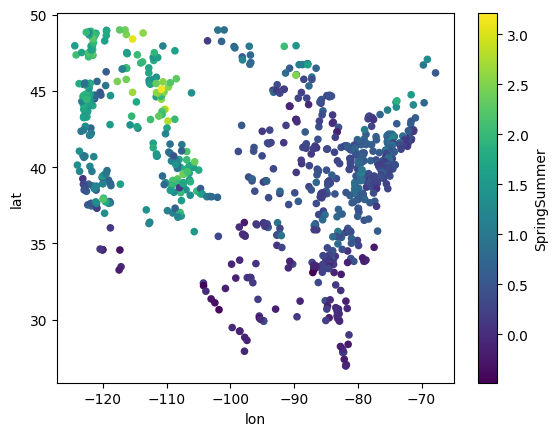

In [16]:
coefs_predicted.plot.scatter(x="lon", y="lat", c="SpringSummer")

# NEXT Class

In [17]:
mod = NEXT.from_preproc_data(tdat)

In [20]:
ws = "394220106431500"
wsd = data[data["id"] == ws]
wsd

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,day,...,elev,elev_min,elev_std,slope,asp_north,asp_east,lat,lon,frozen,cold_prcp
65978,394220106431500,2007-10-01,9.000000,5.684494,315.89957,NaN,14.848049,-0.734184,579.70483,274,...,3027.4941,2084.220703,415.970581,0.000299,0.003461,0.003345,39.705,-106.725833,False,0.000000
65979,394220106431500,2007-10-02,10.131250,1.734530,275.11975,NaN,9.678488,-0.441640,593.09650,275,...,3027.4941,2084.220703,415.970581,0.000299,0.003461,0.003345,39.705,-106.725833,False,0.000000
65980,394220106431500,2007-10-03,9.704167,0.000000,406.70746,NaN,14.444156,-0.781746,576.83930,276,...,3027.4941,2084.220703,415.970581,0.000299,0.003461,0.003345,39.705,-106.725833,False,0.000000
65981,394220106431500,2007-10-04,9.695833,0.405152,387.00244,NaN,16.709568,1.858799,699.66880,277,...,3027.4941,2084.220703,415.970581,0.000299,0.003461,0.003345,39.705,-106.725833,False,0.000000
65982,394220106431500,2007-10-05,10.901042,0.000000,334.83810,NaN,15.645824,3.965081,813.42255,278,...,3027.4941,2084.220703,415.970581,0.000299,0.003461,0.003345,39.705,-106.725833,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71512,394220106431500,2022-12-27,0.000000,10.553032,191.49033,NaN,4.154530,NaN,424.24790,361,...,3027.4941,2084.220703,415.970581,0.000299,0.003461,0.003345,39.705,-106.725833,False,0.000000
71513,394220106431500,2022-12-28,0.000000,8.184340,210.25845,NaN,0.119703,NaN,298.54263,362,...,3027.4941,2084.220703,415.970581,0.000299,0.003461,0.003345,39.705,-106.725833,False,0.000000
71514,394220106431500,2022-12-29,0.000000,1.973018,218.12827,NaN,-7.772742,NaN,180.07483,363,...,3027.4941,2084.220703,415.970581,0.000299,0.003461,0.003345,39.705,-106.725833,True,1.973018
71515,394220106431500,2022-12-30,0.000000,7.100912,229.40940,NaN,-4.506784,NaN,182.08226,364,...,3027.4941,2084.220703,415.970581,0.000299,0.003461,0.003345,39.705,-106.725833,True,7.100912


In [24]:
mod.make_newt(wsd)

In [26]:
mod.get_newt().coefs_to_df()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,R2,RMSE,at_coef,threshold_act_min,threshold_coef_min,threshold_act_cutoff,threshold_coef_max
0,7.734697,6.939098,319.154148,48.268286,142.580707,221.985123,2.110759,2.268175,None,None,0.486783,1.381805,0.069489,4.482282,0.486783
